In [49]:
# Benchmark Datasets
from benchmark import Benchmark

datasets = Benchmark.load_all_benchmark_datasets()

df = datasets["spectrometer"] # datasets["ecoli"]

In [50]:
# Standardize Dataset
from preprocessing import standardize

df = standardize(df)

In [51]:
# Set our RNG seed for reproducibility.
import numpy as np
from config import RANDOM_STATE_SEED
np.random.seed(RANDOM_STATE_SEED)

In [46]:
X_raw = df.loc[:, df.columns != 'target']#.to_numpy()
y_raw = df['target']#.to_numpy()

In [47]:
# PCA decomposition
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_df = pca.fit_transform(X=X_raw)

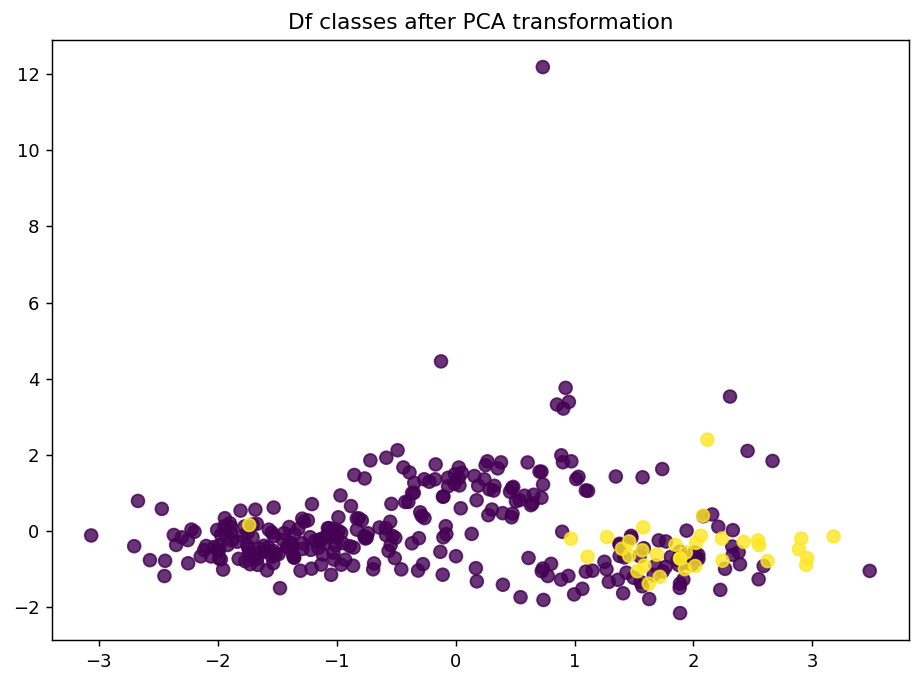

In [48]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_df[:, 0], transformed_df[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Df classes after PCA transformation')
plt.show()

In [40]:
# Samples weighting & Hyperparameters tunning
from config import WEIGHTED_TRAINING

# Samples weighting
from sklearn.utils.class_weight import compute_class_weight

def get_class_weight(y_train_init):
    if WEIGHTED_TRAINING:
        classes_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_init), y=y_train_init)
        CLASS_WEIGHT = {}
        for c, cw in list(zip(np.unique(y_train_init), classes_weights)):
            CLASS_WEIGHT[c] = cw
        print(CLASS_WEIGHT)
    else:
        CLASS_WEIGHT = None
    return CLASS_WEIGHT

# Hyperparameters tunning
from sklearn.base import ClassifierMixin
from sklearn.model_selection._search import  BaseSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, GridSearchCV, HalvingGridSearchCV
from sklearn.utils.class_weight import compute_sample_weight

def tune_classifiers_hyperparameters_cw(Clf: ClassifierMixin, X, y, params_grid, GridSearchMethod: BaseSearchCV,  scorer, class_weight=None, random_state=13, verbose=True) -> tuple:

    skf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
    # Any GridSearch assumes stratified folds if there is classifier
    if issubclass(GridSearchMethod, GridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=params_grid, scoring=scorer, refit=True, cv=skf)
    elif issubclass(GridSearchMethod, HalvingGridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=params_grid, scoring=scorer, refit=True, cv=skf, factor=2)
    else:
        raise ValueError("Unknown or unsupported BaseSearchCV") 

    if class_weight:
        sample_weight = compute_sample_weight(class_weight=class_weight, y=y)
    else:
        sample_weight = None
    gs.fit(X, y, sample_weight=sample_weight)

    if verbose:
        params_combinations = gs.cv_results_["params"]
        params_combinations_scores = gs.cv_results_["mean_test_score"]
        for i, params in enumerate(params_combinations):
            print(f"{params}\n{params_combinations_scores[i]}")

    return (gs.best_estimator_, gs.best_params_)

In [41]:
# Query and batch size
import warnings
from config import StoppingCriterion, BatchMode, AL_N_QUERIES, AL_QUERY_FIXED_BATCH_SIZE, AL_FRACTION_OF_TRAIN_QUERIES, AL_QUERY_FRACTION_OF_TRAIN_BATCH_SIZE
def perpare_queries_and_batch_size(stopping_criterion: StoppingCriterion, batch_mode: BatchMode, pool_size: int, init_train_size: int) -> tuple:
    match stopping_criterion.name:
        case "N_QUERIES":
            n_queries = AL_N_QUERIES
            match batch_mode.name:
                case 'FIXED_BATCH_SIZE':
                    batch_size = AL_QUERY_FIXED_BATCH_SIZE
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
                case 'FRACTION_OF_N_QUERIES':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.") # TODO?
                case 'FRACTION_OF_TRAIN_SIZE':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.") # TODO?
        case "FRACTION_OF_TRAIN_QUERIES":
            n_queries = int((AL_FRACTION_OF_TRAIN_QUERIES * pool_size / 0.9) - init_train_size)
            match batch_mode.name:
                case 'FIXED_BATCH_SIZE':
                    batch_size = AL_QUERY_FIXED_BATCH_SIZE
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
                case 'FRACTION_OF_N_QUERIES':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.")
                case 'FRACTION_OF_TRAIN_SIZE':
                    batch_size = int(AL_QUERY_FRACTION_OF_TRAIN_BATCH_SIZE * pool_size / 0.9)
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
        # TODO: Add debuging of number of queries

        case "ENTROPY_CONFIDENCE":
            n_queries = pool_size
            batch_size = AL_QUERY_FIXED_BATCH_SIZE
            if n_queries * batch_size > pool_size:
                        n_queries = int(n_queries/batch_size)
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
            n_decline_rounds = 0

    if n_queries > pool_size:
        n_queries = pool_size
            

    return n_queries, batch_size

In [42]:
import warnings, copy, time, functools
from collections import Counter
import pandas as pd

from config import TEST_SIZE, INITIAL_TRAIN_SIZE, WEIGHTED_TRAINING, VERBOSE, PARAMS_GRID
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB

from metrics import method_eval, f2_score

from modAL import ActiveLearner
from modAL.random_sampling import random_sampling
from modAL.uncertainty import uncertainty_sampling
from modAL.expected_error import expected_error_reduction
from modAL.uncertainty import classifier_entropy
from modAL.utils.data import data_vstack


def expected_error_reduction_with_loss(func, loss_type: str):
    @functools.wraps(func)
    def loss_wrapper(*args, **kwargs):
        return func(*args, loss=loss_type, **kwargs)
    return loss_wrapper

expected_log_error_reduction = expected_error_reduction_with_loss(expected_error_reduction, loss_type="log")

def al_cv(X_raw: pd.DataFrame, y_raw: pd.DataFrame, Clf = GaussianNB, query_strategy = expected_error_reduction):
    results = {"folds": []}

    # Stratified K-Folds cross-validator
    skf = StratifiedKFold(n_splits=int(1/TEST_SIZE), random_state=RANDOM_STATE_SEED, shuffle=True) 
    for k, (kf_train_indices, kf_test_indices) in enumerate(skf.split(X_raw, y_raw)):

        fold_results = {}

        if VERBOSE:
            print(50*'*')
            print(f"Fold no.{k+1}")
            print(50*'*')

        # K-Fold train and test
        X_train, X_test, y_train, y_test = X_raw.iloc[kf_train_indices], \
        X_raw.iloc[kf_test_indices], y_raw.iloc[kf_train_indices], y_raw.iloc[kf_test_indices]
        
        # K-Fold pool from train
        X_train_init, X_pool, y_train_init, y_pool = train_test_split(X_train, y_train, \
                                                        train_size=INITIAL_TRAIN_SIZE, stratify=y_train, random_state=RANDOM_STATE_SEED)
        

        class_weight = get_class_weight(y_train_init)
        

        _, params = tune_classifiers_hyperparameters_cw(Clf, X_train_init, y_train_init, params_grid=PARAMS_GRID[Clf.__name__], GridSearchMethod=GridSearchCV, scorer=f2_score, class_weight=class_weight, random_state=RANDOM_STATE_SEED, verbose=VERBOSE)
        # params = {}
        sample_weight = compute_sample_weight(class_weight=class_weight, y=y_train_init) if WEIGHTED_TRAINING else None

        learner = ActiveLearner(estimator=Clf(**params), X_training=X_train_init, y_training=y_train_init, query_strategy=query_strategy, sample_weight=sample_weight) # TODO: Refactor to map factory

        model = Clf(**params)

        sample_weight = compute_sample_weight(class_weight=class_weight, y=y_train) if WEIGHTED_TRAINING else None

        model.fit(X_train, y_train, sample_weight=sample_weight)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        print("Full dataset model")
        print(50*'-')
        full_model_score = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
        print(50*'-')

        fold_results["full_model"] = full_model_score

        # Evaluate initial model
        y_pred = learner.predict(X_test)
        y_proba = learner.predict_proba(X_test)

        print("Initial model")
        print(50*'-')
        unqueried_score = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
        print(50*'-')

        fold_results["initial_model"] = unqueried_score

        
        learner_al = copy.deepcopy(learner)
        X_pool_al, y_pool_al = copy.deepcopy(X_pool), copy.deepcopy(y_pool)

        warnings.simplefilter(action='ignore', category=FutureWarning)

        from config import StoppingCriterion, BatchMode, AL_N_DECLINE_ROUNDS
        stopping_criterion  = StoppingCriterion.FRACTION_OF_TRAIN_QUERIES
        batch_mode = BatchMode.FIXED_BATCH_SIZE
        n_queries, batch_size = perpare_queries_and_batch_size(stopping_criterion, batch_mode, len(y_pool_al), len(learner.y_training))

        # AL statistics
        queried_classes_counter = Counter()
        performance_history = [unqueried_score["metrics"]]
        iterations_time_history = []
        initial_confidence = np.mean(classifier_entropy(learner_al, X_test))
        entropy_confidence_history = [initial_confidence]

        if VERBOSE:
            print(50*'=')
            print(f"Active Learning")
            print(50*'=')

        # Allow our model to query unlabeled dataset for the most
        # informative points according to our query strategy (uncertainty sampling).
        for index in range(n_queries):
            if index == 240:
                pass

            start = time.perf_counter()
            query_index, query_instance = learner_al.query(X_pool_al.to_numpy(), n_instances=batch_size)

            # To track which samples are choosen. It is usefull, when comparing different algorithms.
            global_query_index = X_pool_al.iloc[query_index].index

            print(f"\n{index+1}. iteration: \nChosen sample was of an index: {global_query_index[-1]}\nChosen sample was of a class: {y_pool_al.iloc[query_index]}\n")
            queried_classes_counter.update(y_pool_al.iloc[query_index])

            # Teach our ActiveLearner model the record it has requested.
            X, y = X_pool_al.iloc[query_index], y_pool_al.iloc[query_index]
            if WEIGHTED_TRAINING:
                new_y = data_vstack((learner_al.y_training, y))
                sample_weight = compute_sample_weight(class_weight=class_weight, y=new_y)
            else:
                sample_weight = None
            learner_al.teach(X=X.to_numpy(), y=y.to_numpy(), sample_weight=sample_weight) # implicitly it gets fit_kwargs -> sample_weight
            # learner_al.teach(X=X, y=y, sample_weight=sample_weight, bootstrap=True, stratify=True) # for Query-By-Bagging


            # Remove the queried instance from the unlabeled pool.
            X_pool_al, y_pool_al = X_pool_al.drop(global_query_index), y_pool_al.drop(global_query_index)

            # Calculate and report our model's accuracy.
            y_pred = learner_al.predict(X_test)
            y_proba = learner_al.predict_proba(X_test)
            print(50*'-')
            model_evaluation = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
            print(50*'-')

            # Save our model's performance for plotting.
            performance_history.append(model_evaluation["metrics"])

            # Entropy confidence
            entropy_confidence_history.append(np.mean(classifier_entropy(learner_al, X_test)))
            if stopping_criterion == "ENTROPY_CONFIDENCE":
                if entropy_confidence_history[-1] < entropy_confidence_history[-2]:
                    n_decline_rounds += 1
                else:
                    n_decline_rounds = 0
                if n_decline_rounds >= AL_N_DECLINE_ROUNDS:
                    break
                if len(y_pool_al) < batch_size:
                    break
            
            elapsed = time.perf_counter() - start
            iterations_time_history.append(elapsed)
    
        print(f"Queried samples:\n {queried_classes_counter}")
        n_queries = sum(queried_classes_counter.values())
        print(f"{len(y_train_init) + n_queries} out of {len(y_train)} samples seen.")
        print(f"Average iteration time was {np.mean(iterations_time_history):0.2f}s")

        fold_results["al_final_model"] = {"metrics": performance_history[-1]}
        fold_results["al_metrics"] = performance_history
        fold_results["al_confidence"] = entropy_confidence_history
        fold_results["al_queries"] = queried_classes_counter
        fold_results["avg_time_of_query"] = np.mean(iterations_time_history)
        results["folds"].append(fold_results)

    return results

rs_results = al_cv(X_raw, y_raw, Clf=GaussianNB, query_strategy=random_sampling)
us_results = al_cv(X_raw, y_raw, Clf=GaussianNB, query_strategy=uncertainty_sampling)
eer_results = al_cv(X_raw, y_raw, Clf=GaussianNB, query_strategy=expected_error_reduction)


**************************************************
Fold no.1
**************************************************
{'var_smoothing': 1}
0.5333333333333334
{'var_smoothing': 0.001}
0.5666666666666667
{'var_smoothing': 1e-06}
0.5666666666666667
{'var_smoothing': 1e-09}
0.5666666666666667
Full dataset model
--------------------------------------------------
accuracy: 0.9158878504672897,
precision: 0.5,
recall: 0.3333333333333333,
f2_score: 0.3571428571428571,
auc_pr_curve: 0.37762317381634347,
auc_roc_curve: 0.7959183673469388
--------------------------------------------------
Initial model
--------------------------------------------------
accuracy: 0.9439252336448598,
precision: 1.0,
recall: 0.3333333333333333,
f2_score: 0.3846153846153846,
auc_pr_curve: 0.41708066246634806,
auc_roc_curve: 0.7131519274376417
--------------------------------------------------
Active Learning

1. iteration: 
Chosen sample was of an index: 521
Chosen sample was of a class: 521   -1
Name: target, dtype: int64


/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


--------------------------------------------------
accuracy: 0.9439252336448598,
precision: 1.0,
recall: 0.3333333333333333,
f2_score: 0.3846153846153846,
auc_pr_curve: 0.4126036536420309,
auc_roc_curve: 0.7029478458049887
--------------------------------------------------

23. iteration: 
Chosen sample was of an index: 105
Chosen sample was of a class: 105   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9439252336448598,
precision: 1.0,
recall: 0.3333333333333333,
f2_score: 0.3846153846153846,
auc_pr_curve: 0.4132381266103099,
auc_roc_curve: 0.7063492063492063
--------------------------------------------------

24. iteration: 
Chosen sample was of an index: 424
Chosen sample was of a class: 424   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9439252336448598,
precision: 1.0,
recall: 0.3333333333333333,
f2_score: 0.3846153846153846,
auc_pr_curve: 0.40853635733355176,
auc_roc_curve: 0.6859410

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



22. iteration: 
Chosen sample was of an index: 352
Chosen sample was of a class: 352   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5,
recall: 0.5555555555555556,
f2_score: 0.5434782608695652,
auc_pr_curve: 0.5103631212797238,
auc_roc_curve: 0.6116838487972508
--------------------------------------------------

23. iteration: 
Chosen sample was of an index: 227
Chosen sample was of a class: 227   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5,
recall: 0.5555555555555556,
f2_score: 0.5434782608695652,
auc_pr_curve: 0.5103631212797238,
auc_roc_curve: 0.6116838487972508
--------------------------------------------------

24. iteration: 
Chosen sample was of an index: 471
Chosen sample was of a class: 471   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


accuracy: 0.9056603773584906,
precision: 0.42857142857142855,
recall: 0.3333333333333333,
f2_score: 0.3488372093023256,
auc_pr_curve: 0.3360391412674415,
auc_roc_curve: 0.7514318442153494
--------------------------------------------------
Initial model
--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5,
recall: 0.2222222222222222,
f2_score: 0.25,
auc_pr_curve: 0.3457736157709773,
auc_roc_curve: 0.5475372279495991
--------------------------------------------------
Active Learning

1. iteration: 
Chosen sample was of an index: 392
Chosen sample was of a class: 392   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5,
recall: 0.2222222222222222,
f2_score: 0.25,
auc_pr_curve: 0.3457736157709773,
auc_roc_curve: 0.5475372279495991
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 305
Chosen sample was of a class: 305   -1
Nam

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


--------------------------------------------------
accuracy: 0.9056603773584906,
precision: 0.4444444444444444,
recall: 0.4444444444444444,
f2_score: 0.4444444444444444,
auc_pr_curve: 0.40638119792491284,
auc_roc_curve: 0.4627720504009163
--------------------------------------------------

14. iteration: 
Chosen sample was of an index: 43
Chosen sample was of a class: 43   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9056603773584906,
precision: 0.4444444444444444,
recall: 0.4444444444444444,
f2_score: 0.4444444444444444,
auc_pr_curve: 0.4063149437298605,
auc_roc_curve: 0.4616265750286368
--------------------------------------------------

15. iteration: 
Chosen sample was of an index: 419
Chosen sample was of a class: 419   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9056603773584906,
precision: 0.4444444444444444,
recall: 0.4444444444444444,
f2_score: 0.4444444444444444,
auc_pr_curve: 0

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'var_smoothing': 1}
0.4
{'var_smoothing': 0.001}
0.4
{'var_smoothing': 1e-06}
0.4
{'var_smoothing': 1e-09}
0.4
Full dataset model
--------------------------------------------------
accuracy: 0.9245283018867925,
precision: 0.5555555555555556,
recall: 0.5555555555555556,
f2_score: 0.5555555555555556,
auc_pr_curve: 0.46083616990038156,
auc_roc_curve: 0.8064146620847652
--------------------------------------------------
Initial model
--------------------------------------------------
accuracy: 0.9245283018867925,
precision: 0.5555555555555556,
recall: 0.5555555555555556,
f2_score: 0.5555555555555556,
auc_pr_curve: 0.47285877960341516,
auc_roc_curve: 0.699885452462772
--------------------------------------------------
Active Learning

1. iteration: 
Chosen sample was of an index: 451
Chosen sample was of a class: 451   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9245283018867925,
precision: 0.5555555555555556,
recall: 0.5555555555555556,
f2

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



12. iteration: 
Chosen sample was of an index: 396
Chosen sample was of a class: 396    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9345794392523364,
precision: 0.75,
recall: 0.3333333333333333,
f2_score: 0.375,
auc_pr_curve: 0.3676726112963396,
auc_roc_curve: 0.687641723356009
--------------------------------------------------

13. iteration: 
Chosen sample was of an index: 186
Chosen sample was of a class: 186   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9345794392523364,
precision: 0.75,
recall: 0.3333333333333333,
f2_score: 0.375,
auc_pr_curve: 0.3701489203003485,
auc_roc_curve: 0.6989795918367346
--------------------------------------------------

14. iteration: 
Chosen sample was of an index: 158
Chosen sample was of a class: 158   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9345794392523364,
precision: 0.75,
recall: 0.333333333333

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


--------------------------------------------------
accuracy: 0.9433962264150944,
precision: 0.7142857142857143,
recall: 0.5555555555555556,
f2_score: 0.5813953488372093,
auc_pr_curve: 0.5866549393521497,
auc_roc_curve: 0.5761741122565865
--------------------------------------------------

14. iteration: 
Chosen sample was of an index: 143
Chosen sample was of a class: 143   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9433962264150944,
precision: 0.7142857142857143,
recall: 0.5555555555555556,
f2_score: 0.5813953488372093,
auc_pr_curve: 0.5867337821518372,
auc_roc_curve: 0.5773195876288659
--------------------------------------------------

15. iteration: 
Chosen sample was of an index: 295
Chosen sample was of a class: 295   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9528301886792453,
precision: 0.8333333333333334,
recall: 0.5555555555555556,
f2_score: 0.5952380952380952,
auc_pr_curve: 

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5,
recall: 0.2222222222222222,
f2_score: 0.25,
auc_pr_curve: 0.3966665028729137,
auc_roc_curve: 0.5544100801832761
--------------------------------------------------

15. iteration: 
Chosen sample was of an index: 295
Chosen sample was of a class: 295   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5,
recall: 0.2222222222222222,
f2_score: 0.25,
auc_pr_curve: 0.3966665028729137,
auc_roc_curve: 0.5544100801832761
--------------------------------------------------

16. iteration: 
Chosen sample was of an index: 516
Chosen sample was of a class: 516   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5,
recall: 0.2222222222222222,
f2_score: 0.25,
auc_pr_curve: 0.3996172558236667,
auc_roc_curve: 0.5555555555555556
---------------------------------

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


accuracy: 0.9433962264150944,
precision: 0.8,
recall: 0.4444444444444444,
f2_score: 0.4878048780487804,
auc_pr_curve: 0.4792739672267119,
auc_roc_curve: 0.4455899198167239
--------------------------------------------------

15. iteration: 
Chosen sample was of an index: 121
Chosen sample was of a class: 121    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9339622641509434,
precision: 0.6666666666666666,
recall: 0.4444444444444444,
f2_score: 0.47619047619047616,
auc_pr_curve: 0.4800419609204505,
auc_roc_curve: 0.46048109965635736
--------------------------------------------------

16. iteration: 
Chosen sample was of an index: 43
Chosen sample was of a class: 43   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9339622641509434,
precision: 0.6666666666666666,
recall: 0.4444444444444444,
f2_score: 0.47619047619047616,
auc_pr_curve: 0.4798511857575963,
auc_roc_curve: 0.4570446735395189
-----------

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5,
recall: 0.4444444444444444,
f2_score: 0.45454545454545453,
auc_pr_curve: 0.4909530671721904,
auc_roc_curve: 0.586483390607102
--------------------------------------------------

16. iteration: 
Chosen sample was of an index: 166
Chosen sample was of a class: 166   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9150943396226415,
precision: 0.5,
recall: 0.4444444444444444,
f2_score: 0.45454545454545453,
auc_pr_curve: 0.4909530671721904,
auc_roc_curve: 0.586483390607102
--------------------------------------------------

17. iteration: 
Chosen sample was of an index: 31
Chosen sample was of a class: 31   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9245283018867925,
precision: 0.5714285714285714,
recall: 0.4444444444444444,
f2_score: 0.4651162790697673,
auc_pr_curve: 0.4909530671721904,
auc_roc_curv

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



1. iteration: 
Chosen sample was of an index: 234
Chosen sample was of a class: 234    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9252336448598131,
precision: 0.6,
recall: 0.3333333333333333,
f2_score: 0.36585365853658536,
auc_pr_curve: 0.3660902952750841,
auc_roc_curve: 0.6785714285714286
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 111
Chosen sample was of a class: 111    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9252336448598131,
precision: 0.6,
recall: 0.3333333333333333,
f2_score: 0.36585365853658536,
auc_pr_curve: 0.34903207142360665,
auc_roc_curve: 0.5742630385487528
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 237
Chosen sample was of a class: 237   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9252336448598131,
precision: 0.6

TypeError: <class 'numpy.ndarray'> datatype is not supported

In [ ]:
original_string = """
accuracy: 0.8823529411764706,
precision: 0.4444444444444444,
recall: 0.5714285714285714,
f2_score: 0.5405405405405406,
auc_pr_curve: 0.4960525148781807,
auc_roc_curve: 0.8220140515222482
"""

# Extract numerical values using regular expressions
import re
values = re.findall(r'\d+\.\d+', original_string)

# Format the values as requested
formatted_string = ' & '.join(map(lambda x: f"{float(x):.4f}", values))

print(formatted_string)

0.8824 & 0.4444 & 0.5714 & 0.5405 & 0.4961 & 0.8220


In [ ]:
# Metrics averaging
results = eer_results
## Extracting information
cv_results = {}
for fold in results["folds"]:
    for k in fold.keys():
        if "model" in k:
            if k in cv_results:
                for m in cv_results[k].keys():
                    cv_results[k][m] += fold[k]["metrics"][m]
            else:
                cv_results[k] = fold[k]["metrics"]

folds_no = len(results["folds"])

if VERBOSE:
        print(50*'=')
        print(f"Averaged CV results")
        print(50*'=')

## Averaging
for model in cv_results.keys():
    if VERBOSE:
        print(50*'*')
        print(f"{model}")
        print(50*'*')
    for metric in cv_results[model]:
        cv_results[model][metric] /= folds_no
        if VERBOSE:
            print(f"'{metric}': ", cv_results[model][metric])

Averaged CV results
**************************************************
full_model
**************************************************
'accuracy':  0.8302019315188762
'precision':  0.38230463199772663
'recall':  0.8
'f2_score':  0.6352521639286346
'auc_pr_curve':  0.5423500856400314
'auc_roc_curve':  0.9024980483996877
**************************************************
initial_model
**************************************************
'accuracy':  0.8928446005267778
'precision':  0.3942857142857143
'recall':  0.3142857142857142
'f2_score':  0.32562706900942195
'auc_pr_curve':  0.5197634745172808
'auc_roc_curve':  0.891896955503513
**************************************************
al_final_model
**************************************************
'accuracy':  0.8719490781387181
'precision':  0.3246428571428571
'recall':  0.5142857142857142
'f2_score':  0.4440039440723435
'auc_pr_curve':  0.47593239194899734
'auc_roc_curve':  0.8989461358313818


In [ ]:
for model in cv_results.keys():
    print(model)
    for x in cv_results[model].values():
        print(f"{x:.4f} & ", end="")
    print("\n")

full_model
0.8302 & 0.3823 & 0.8000 & 0.6353 & 0.5424 & 0.9025 & 

initial_model
0.8928 & 0.3943 & 0.3143 & 0.3256 & 0.5198 & 0.8919 & 

al_final_model
0.8719 & 0.3246 & 0.5143 & 0.4440 & 0.4759 & 0.8989 & 



/var/folders/qp/fbwnh2d13p51dc53m43g8vc40000gn/T/ipykernel_69244/3817721371.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


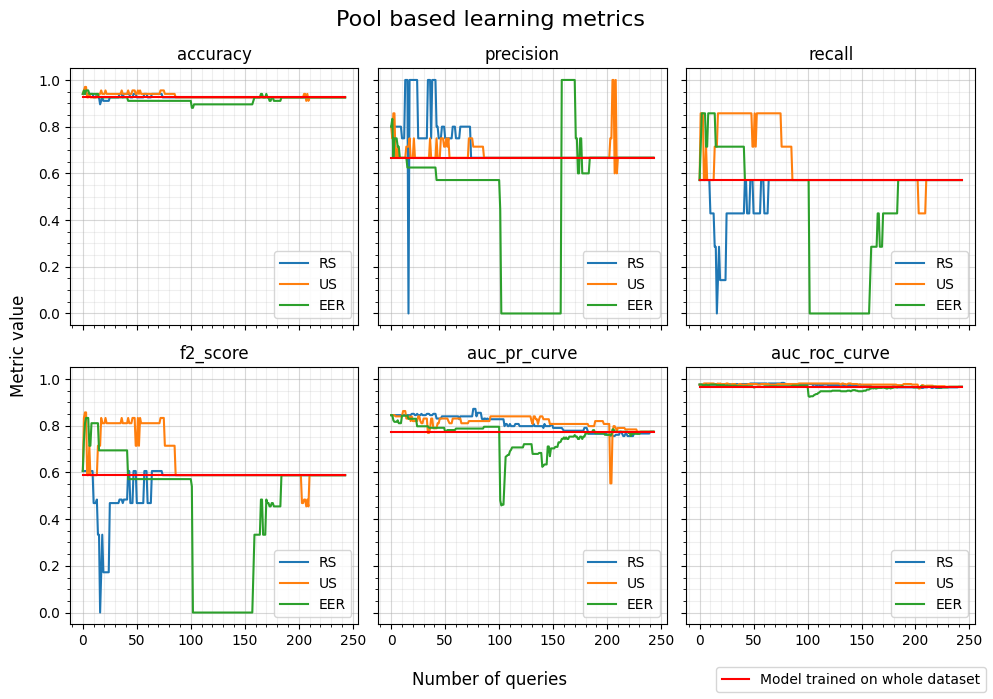

In [ ]:
from matplotlib import pyplot as plt

# Fold
fold = 0 # 0-4

full_model_score = rs_results["folds"][fold]["full_model"]
if len(full_model_score) == 2:
    full_model_score = list(full_model_score["metrics"].values())
rs_performance_history = rs_results["folds"][fold]["al_metrics"]
us_performance_history = us_results["folds"][fold]["al_metrics"]
err_performance_history = eer_results["folds"][fold]["al_metrics"]

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

def plot_metrics(fig, axs, method, performance_history, full_model_score=None):

    metrics = list(zip(*[x.values() for x in performance_history]))

    for i, metric_name in enumerate(performance_history[0].keys()):
        ax = axs[int(i/3), int(i%3)]
        ax.plot(range(len(metrics[i])), metrics[i], label=method)
        if full_model_score:
            handle = ax.plot(range(len(metrics[i])), np.ones(len(metrics[i]))*full_model_score[i], "r")
        ax.set_title(metric_name)
        ax.legend(loc='lower right')
        ax.minorticks_on()
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

    if full_model_score:
        return fig, axs, handle
    else:
        return fig, axs

fig, axs = plot_metrics(fig, axs, method="RS", performance_history=rs_performance_history)
fig, axs = plot_metrics(fig, axs, method="US", performance_history=us_performance_history)
fig, axs, handle = plot_metrics(fig, axs, method="EER", performance_history=err_performance_history, full_model_score=full_model_score)

fig.suptitle("Pool based learning metrics", fontsize=16)
fig.supxlabel("Number of queries")
fig.supylabel("Metric value")
fig.legend(handle, ["Model trained on whole dataset"], loc='lower right')

fig.tight_layout()
fig.show()